In [4]:
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

import multirtd.params as params
from multirtd.utils import plot_trajectory
from multirtd.planners.dubins_planner import DubinsPlanner
from multirtd.dynamics.diff_drive_dynamics import DiffDriveDynamics
from multirtd.sensors.position_sensor import PositionSensor
from multirtd.controllers.lqr_controller import LQRController
from multirtd.estimators.ekf import EKF
from multirtd.turtlebot import Turtlebot

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Text(0, 0.5, 'y')

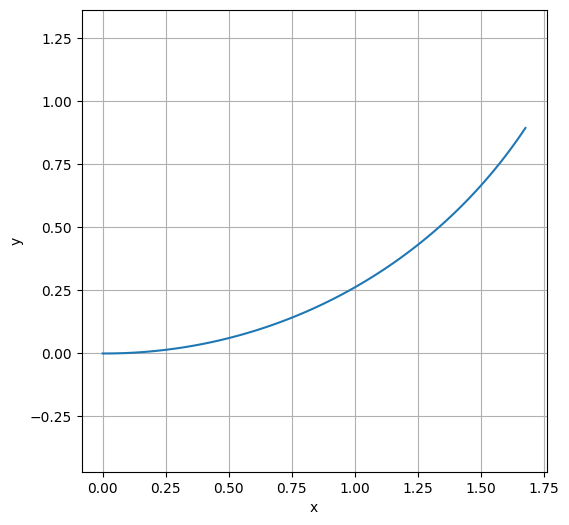

In [5]:
dynamics = DiffDriveDynamics(sigma=0.01)
sensor = PositionSensor(n=2, sigma=0.1)

x0 = np.array([0, 0, 0])
u = np.array([0.2, 0.1])
N = 100
x_nom = dynamics.nominal_traj(x0, u, N)
u_nom = np.tile(u, (N, 1))

# Open-loop trajectory

# Plot nominal trajectory
fig, ax = plt.subplots(figsize=(6,6))
plot_trajectory(ax, x_nom)
ax.axis('equal')
ax.grid(True)
ax.set_xlabel('x')
ax.set_ylabel('y')

In [13]:
controller = LQRController(dynamics)

motion_sigma = dynamics.sigma  # Uncertainty in left/right wheel velocities
range_sigma = sensor.sigma
Q_motion = motion_sigma**2 * np.eye(2)
R_sense = range_sigma**2 * np.eye(2)

estimator = EKF(dynamics, sensor, Q=Q_motion, R=R_sense)

In [14]:
#np.random.seed(0)

# Test EKF implementation

N_MC = 100
x_traj_MC = np.zeros((N_MC, N, 3))

for k in tqdm(range(N_MC)):
    x = np.array([0.0, 0.0, 0.0])
    estimator.x_est = x0
    estimator.P = 0.1 * np.eye(3)

    x_traj = np.zeros((N, 3))
    x_traj_est = np.zeros((N, 3))

    for i in range(1, N):
        # Linearize about nominal trajectory
        A, B = dynamics.linearize(x_nom[i], u_nom[i])
        C = dynamics.noise_matrix(x_nom[i])
        H = sensor.linearize(x_nom[i])

        # Control
        u = controller.get_control(u_nom[i], x_nom[i], estimator.x_est)
        x = dynamics.step(x, u)

        # Measurement
        z = sensor.get_measurement(x)
        
        # EKF
        estimator.update(u, z)

        x_traj[i] = x
        x_traj_est[i] = estimator.x_est
    
    x_traj_MC[k] = x_traj

100%|██████████| 100/100 [01:33<00:00,  1.07it/s]


Text(0, 0.5, 'y')

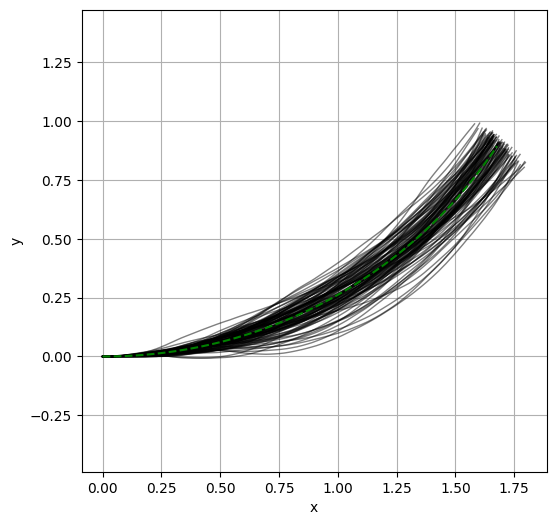

In [15]:
# Plot nominal trajectory
fig, ax = plt.subplots(figsize=(6,6))

for k in range(N_MC):
    plot_trajectory(ax, x_traj_MC[k], color='k', linewidth=1, alpha=0.5)

plot_trajectory(ax, x_nom, color='g', linestyle='dashed')
ax.axis('equal')
ax.grid(True)
ax.set_xlabel('x')
ax.set_ylabel('y')

In [16]:
turtlebot = Turtlebot(x0=x0, dynamics=dynamics, sensor=sensor, controller=controller, estimator=estimator)
turtlebot.estimator.P = 0.1 * np.eye(3)

In [32]:
turtlebot = Turtlebot(x0=x0)
P0 = 1e-4 * np.eye(3)

In [33]:
x_traj_MC = np.zeros((N_MC, N, 3))

for i in tqdm(range(N_MC)):
    turtlebot.reset(x0, P0)
    turtlebot.clear_history()
    turtlebot.track(x_nom, u_nom)
    x_traj_MC[i] = np.stack(turtlebot.x_hist)

100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


In [35]:
turtlebot.estimator.P

array([[ 0.00044589, -0.00030635, -0.00109746],
       [-0.00030635,  0.0003733 ,  0.0008065 ],
       [-0.00109746,  0.0008065 ,  0.00525366]])

Text(0, 0.5, 'y')

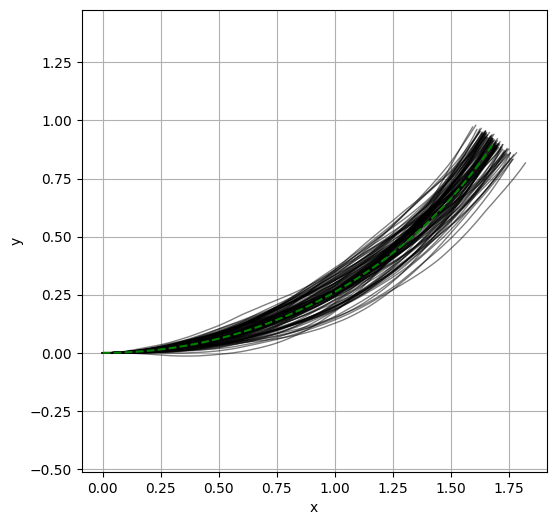

In [34]:
# Plot nominal trajectory
fig, ax = plt.subplots(figsize=(6,6))

for k in range(N_MC):
    plot_trajectory(ax, x_traj_MC[k], color='k', linewidth=1, alpha=0.5)

plot_trajectory(ax, x_nom, color='g', linestyle='dashed')
ax.axis('equal')
ax.grid(True)
ax.set_xlabel('x')
ax.set_ylabel('y')

In [30]:
from multirtd.reachability.dubins_reachability import RRBT

rrbt = RRBT(x_nom, u_nom, 1e-4*np.eye(3), N*[Q_motion], N*[R_sense], turtlebot)

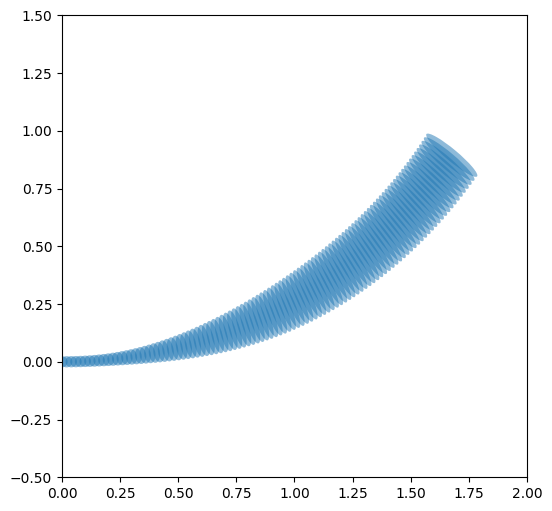

In [31]:
from multirtd.utils import plot_ellipse

fig, ax = plt.subplots(figsize=(6, 6))

for i, e in enumerate(rrbt):
    plot_ellipse(ax, x_nom[i], e[:2,:2])

ax.set_xlim(0.0, 2.0)
ax.set_ylim(-0.5, 1.5)
plt.show()